# Identify higher uplift users profile

The goal is to translate the previous model predictions into actionable insights: identifying the types of users who are most likely to respond positively to treatment (high uplift). Understanding these high-uplift segments enables more efficient targeting and better allocation of marketing resources.

We will analyze the top-percentile users ranked by predicted uplift, compare their feature distributions against the general population, and highlight the most important characteristics that define the optimal target audience.

In [12]:
import numpy as np 
import pandas as pd 

DATA_PATH = '../data/raw/criteo-uplift-v2.1.csv'

df = pd.read_csv(DATA_PATH)

# df.drop(columns = ['f4','f8','f9','f10'], inplace = True)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,13979592.0,19.620297,5.377464,12.616365,12.616365,21.923413,24.436459,26.745255
f1,13979592.0,10.069977,0.104756,10.059654,10.059654,10.059654,10.059654,16.344187
f2,13979592.0,8.446582,0.299316,8.214383,8.214383,8.214383,8.723335,9.051962
f3,13979592.0,4.178923,1.336645,-8.398387,4.679882,4.679882,4.679882,4.679882
f4,13979592.0,10.338837,0.343308,10.280525,10.280525,10.280525,10.280525,21.123508
f5,13979592.0,4.028513,0.431097,-9.011892,4.115453,4.115453,4.115453,4.115453
f6,13979592.0,-4.155356,4.577914,-31.429784,-6.699321,-2.411115,0.294443,0.294443
f7,13979592.0,5.101765,1.205248,4.833815,4.833815,4.833815,4.833815,11.998401
f8,13979592.0,3.933581,0.056660,3.635107,3.910792,3.971858,3.971858,3.971858
f9,13979592.0,16.027638,7.018975,13.190056,13.190056,13.190056,13.190056,75.295017


In [13]:
# Load the two models from previous notebook
import joblib

model_treatment = joblib.load('model_treatment.joblib')
model_control = joblib.load('model_control.joblib')


Using the trained treatment and control models, we predict the probability of conversion for each user under treatment and control, and compute the individual uplift as the difference:

$$
\text{Uplift (X) =   } P(Y = 1| T = 1| X) - P(Y = 1 | T = 0 | X)
$$

In [15]:
feature_cols = [f'f{i}' for i in range(12) ]

# Predict probabilities
df['p_treatment'] = model_treatment.predict_proba(df[feature_cols])[:,1]
df['p_control'] = model_control.predict_proba(df[feature_cols])[:,1]

# Compute predicted uplift
df['uplift_score'] = df['p_treatment'] - df['p_control']


In [16]:
# Sort by predicted uplift descending
df_sorted = df.sort_values('uplift_score', ascending=False).reset_index(drop=True)

# Define top percentiles to analyze
top_percentiles = [0.05, 0.10, 0.20]
top_indices = [int(p * len(df_sorted)) for p in top_percentiles]

# Create a dictionary to store top segments
top_segments = {p: df_sorted.iloc[:k] for p, k in zip(top_percentiles, top_indices)}


### Compare Feature Distributions

For each top-percentile segment, we compare the distribution against the overall population. This should highlight which characteristics define high-uplift users.


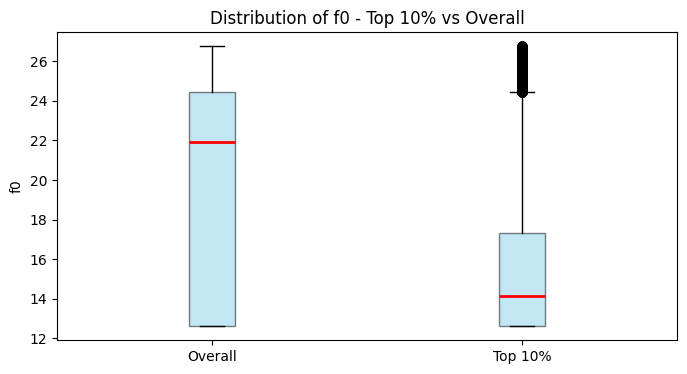

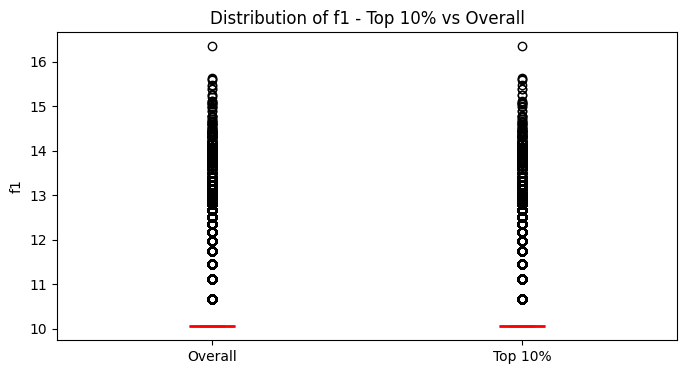

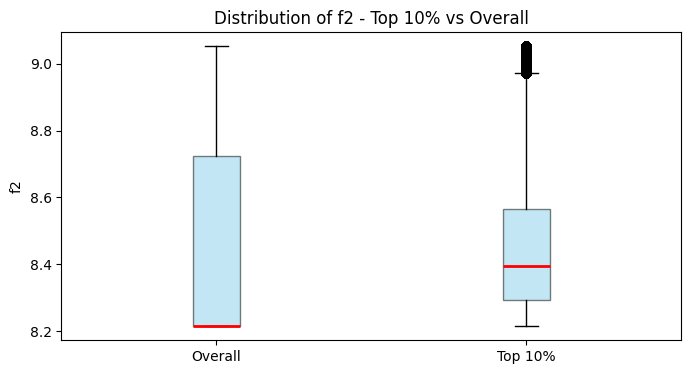

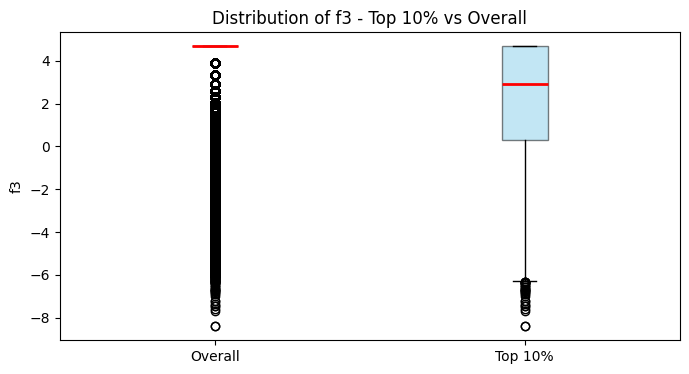

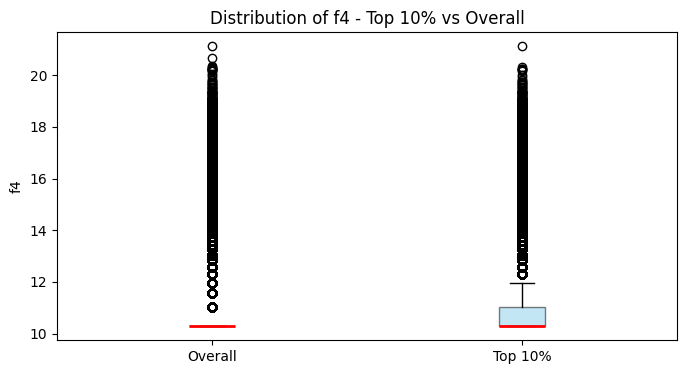

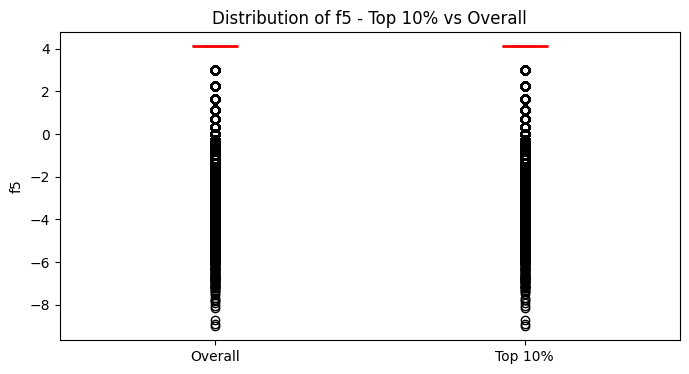

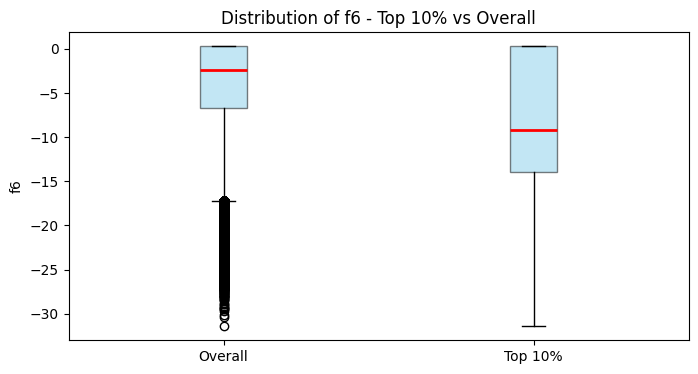

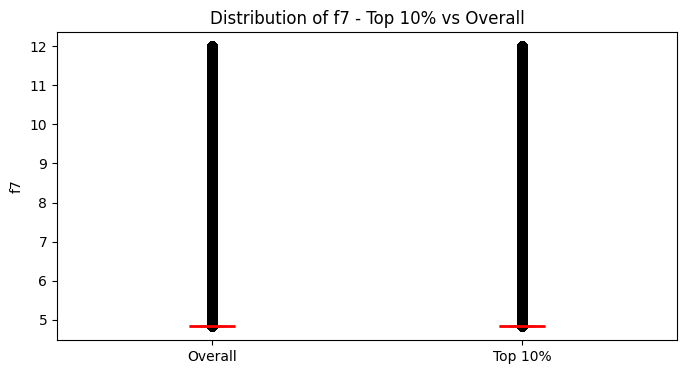

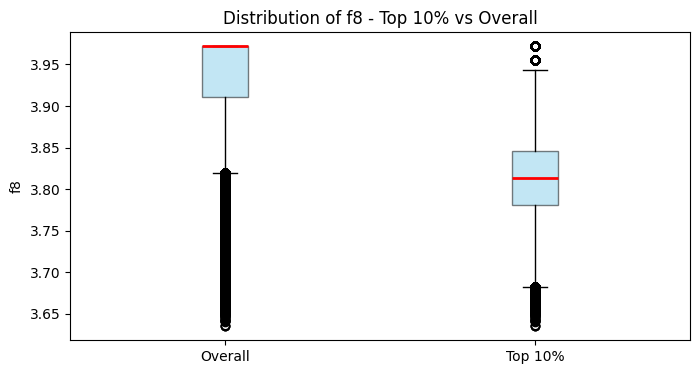

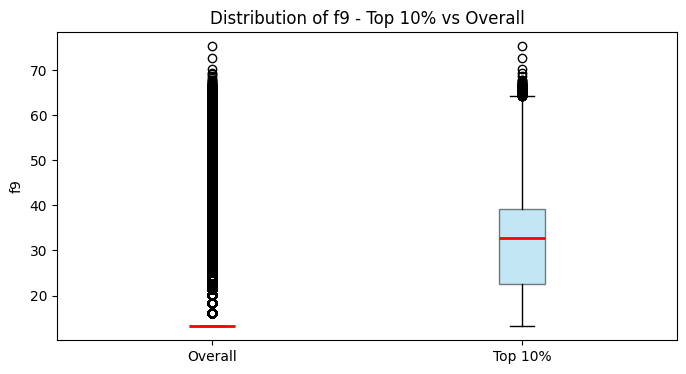

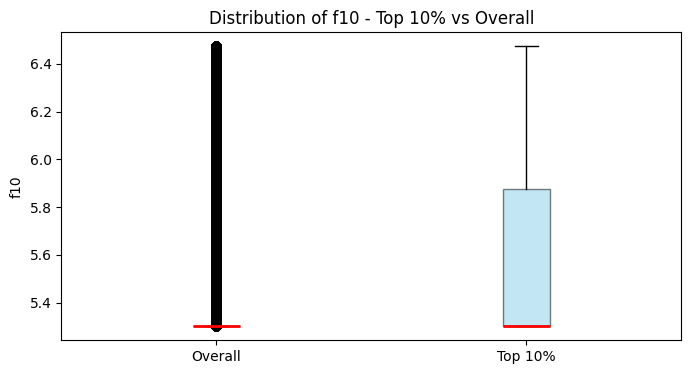

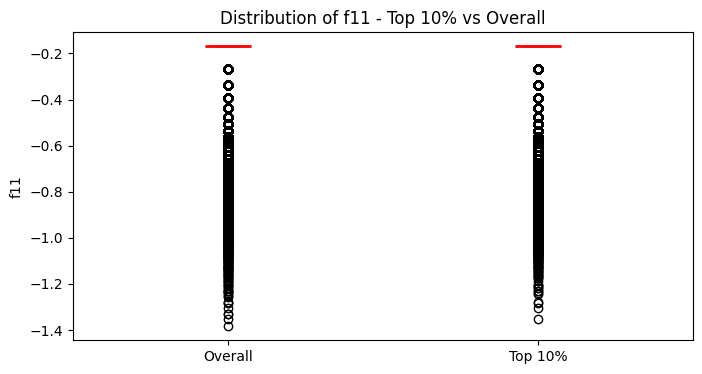

In [17]:
import matplotlib.pyplot as plt

top_10 = top_segments[0.10]

for f in feature_cols:
    plt.figure(figsize=(8,4))
    plt.boxplot([df[f], top_10[f]], tick_labels=['Overall', 'Top 10%'], patch_artist=True,
                boxprops=dict(facecolor='skyblue', alpha=0.5),
                medianprops=dict(color='red', linewidth=2))
    plt.title(f"Distribution of {f} - Top 10% vs Overall")
    plt.ylabel(f)
    plt.show()


Plot normalized histograms (density) to better visualize how the distributions differ.

- f0: top10 shows a similar distribution but with more weight at lower values. Indeed, top10 decays in density at higher values showing a first clue for high-uplift users.
- f1: top10 shows almost the same distribution than the global one due to the high concentration of counts at the lowest value
- f2: top10 behaves like a mix, it shows a high concentration at the lowest value (like the global distribution) but decays faster in density at higher values.
- f3: top10 looks almost like global but with less concentration at the highest value. This changes the distribution a lot and moves the mean to lower values.
- f4: almost the same distribution bu with less concentration.
- f5: there are no significant changes between ditributions.
- f6: big change in the top10 distribution, moving the mean to lowest values and lowering the high concentration at the highest value.
- f7: same distribution but with less concentration. No significant changes.
- f8: huge change, moving the mean to lowest values and breaking the high concentration at the highest value
- f9: breaks the concentration at the lowest value and move the mean to higher values.
- f10: same ditribution less concentrated at the lowest value, moves the mean to higher values.
- f11: same distribution...

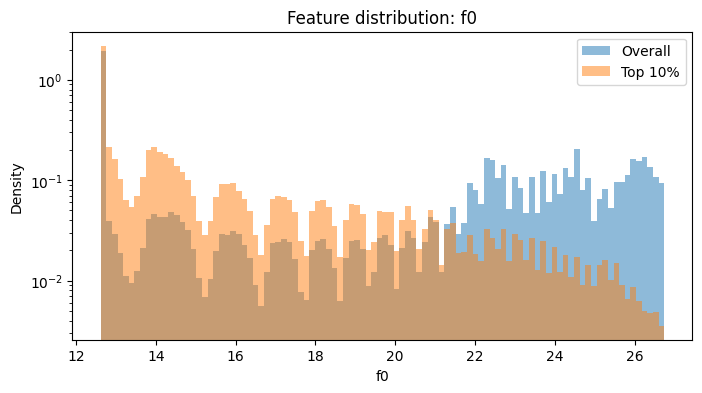

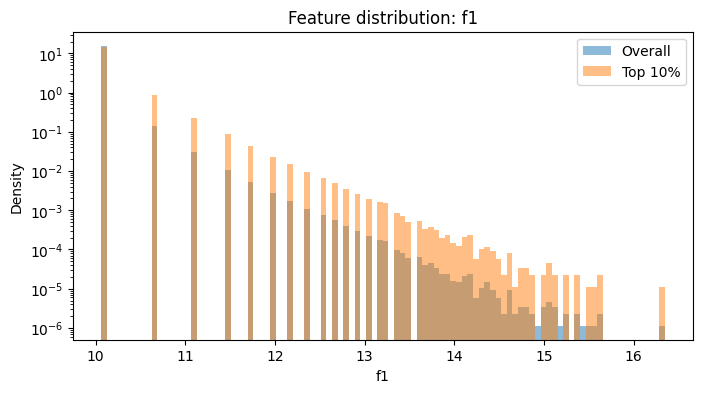

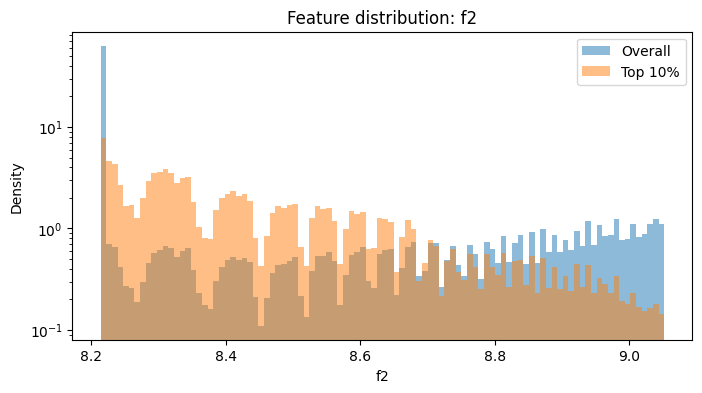

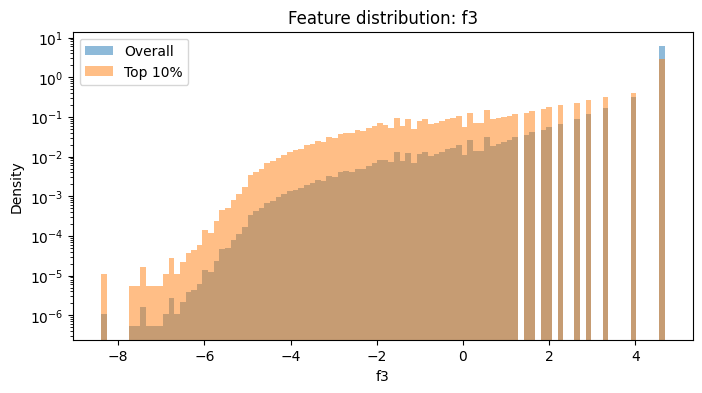

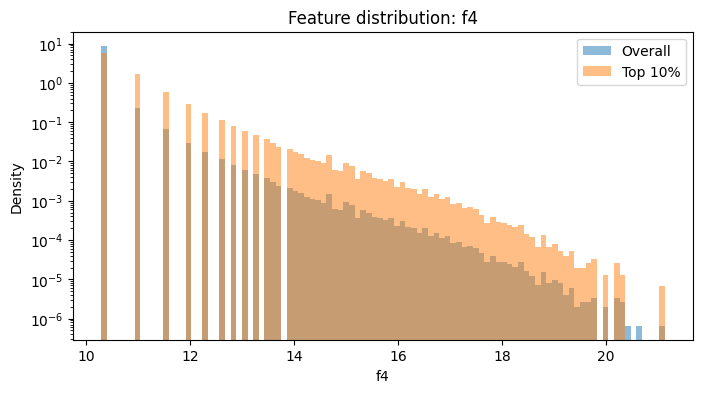

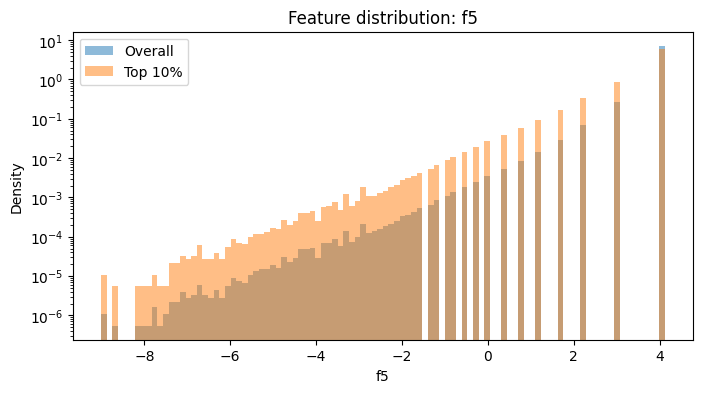

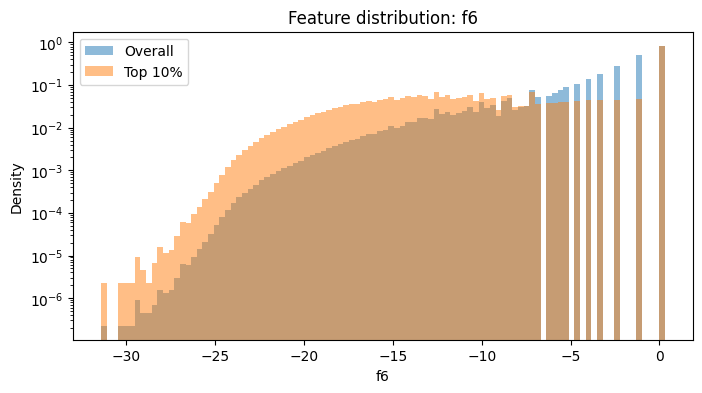

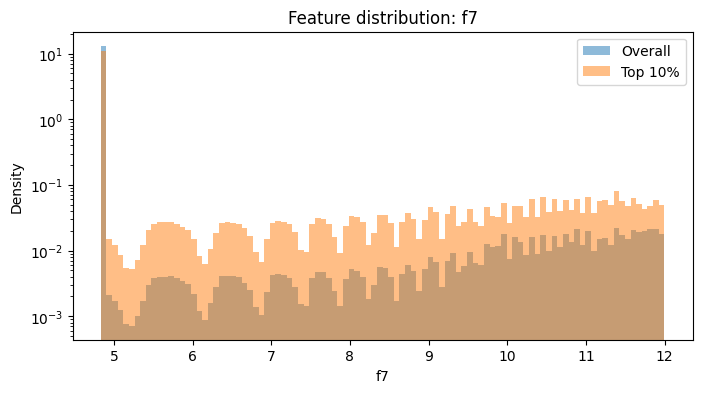

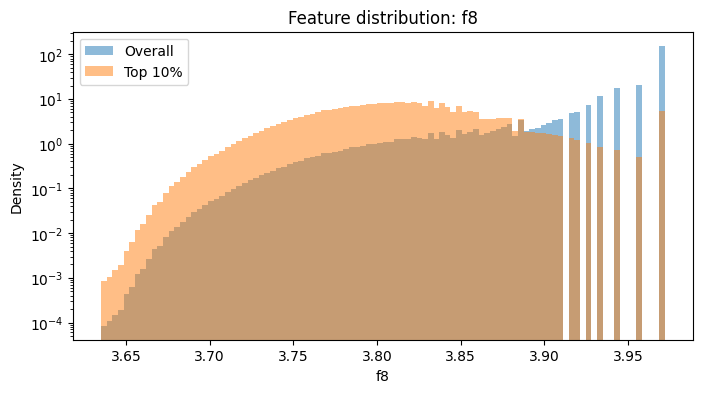

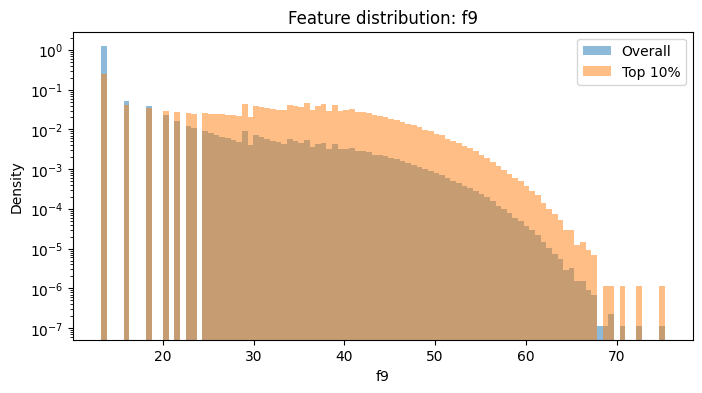

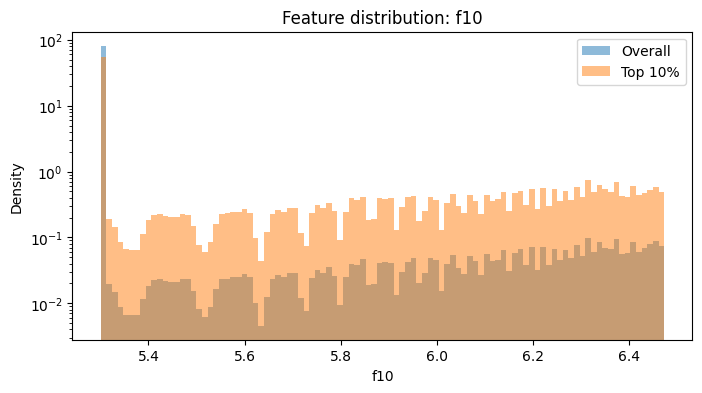

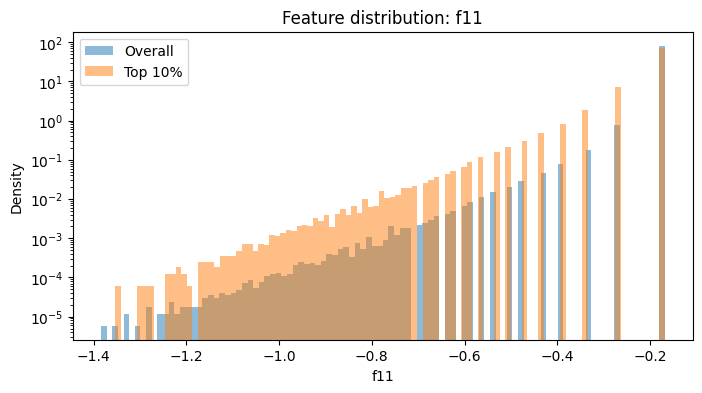

In [18]:
# Logarithmic histograms global vs top 10%
for f in feature_cols:
    plt.figure(figsize=(8,4))
    plt.hist(df[f], bins=100, density=True, log = True, alpha=0.5, label='Overall')
    plt.hist(top_10[f], bins=100, density=True, log = True, alpha=0.5, label='Top 10%')
    plt.title(f"Feature distribution: {f}")
    plt.xlabel(f)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


### Logistic coefficients analysis

We can estimate the relative contribution of each feature to uplift by comparing the coefficients of the treatment and control logistic models. 

Since both models are trained separately, the difference in coefficients indicates which features push more towards conversion under treatment versus control. Positive differences suggest features that increase uplift, negative differences indicate the opposite.


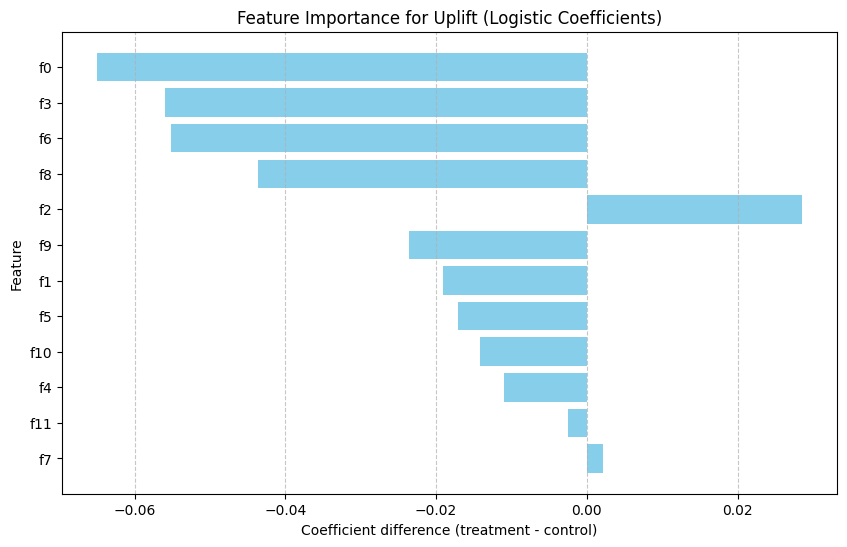

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract coefficients from pipelines
coef_treatment = model_treatment.named_steps['logreg'].coef_[0]
coef_control = model_control.named_steps['logreg'].coef_[0]

# Differential coefficient (approximate importance for uplift)
coef_diff = coef_treatment - coef_control

# Sort features by absolute effect
sorted_idx = np.argsort(np.abs(coef_diff))[::-1]

plt.figure(figsize=(10,6))
plt.barh([feature_cols[i] for i in sorted_idx], coef_diff[sorted_idx], color='skyblue')
plt.xlabel("Coefficient difference (treatment - control)")
plt.ylabel("Feature")
plt.title("Feature Importance for Uplift (Logistic Coefficients)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


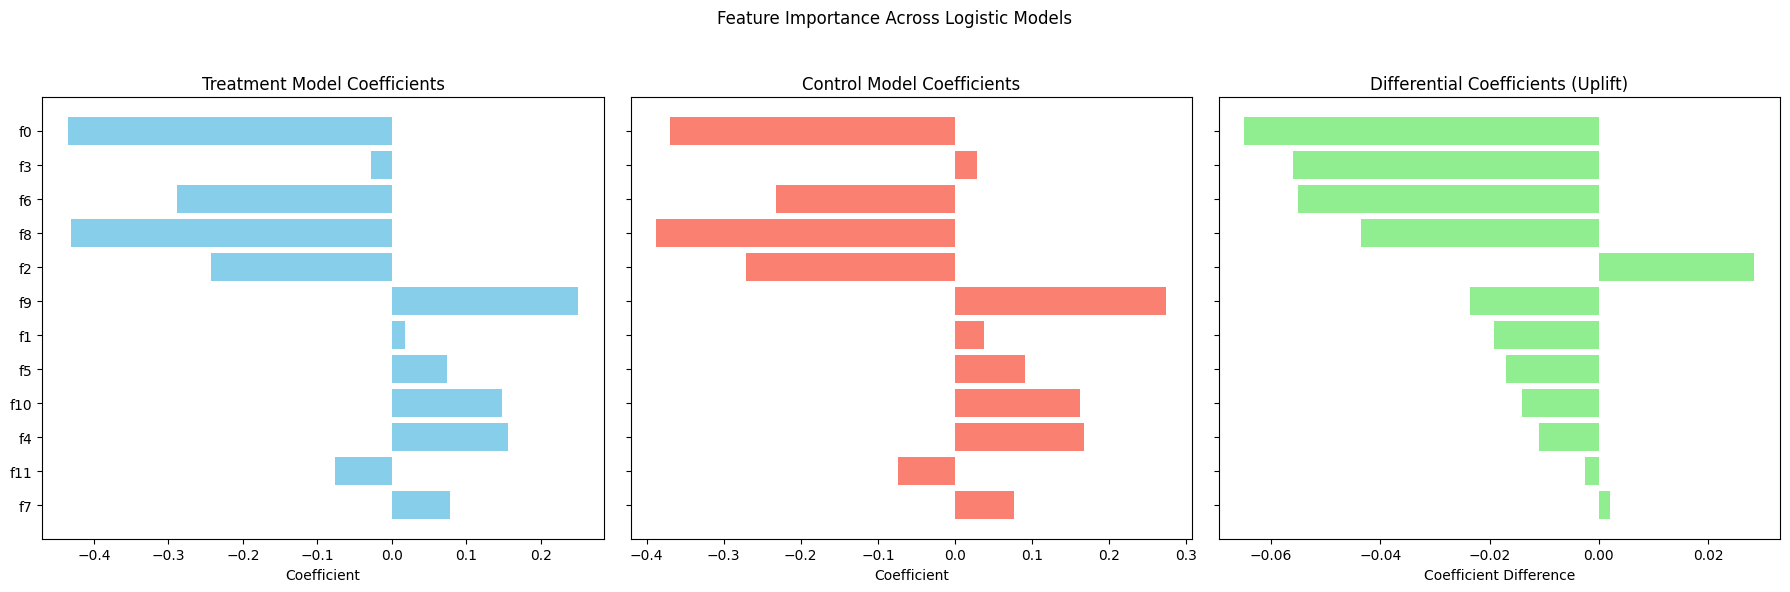

In [20]:
# Extract coefficients from pipelines
coef_treat = model_treatment.named_steps['logreg'].coef_[0]
coef_ctrl  = model_control.named_steps['logreg'].coef_[0]
coef_diff  = coef_treat - coef_ctrl

# Sort features by absolute differential coefficient
sorted_idx = np.argsort(np.abs(coef_diff))[::-1]
sorted_features = [feature_cols[i] for i in sorted_idx]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].barh(sorted_features, coef_treat[sorted_idx], color='skyblue')
axes[0].set_title("Treatment Model Coefficients")
axes[0].invert_yaxis()
axes[0].set_xlabel("Coefficient")

axes[1].barh(sorted_features, coef_ctrl[sorted_idx], color='salmon')
axes[1].set_title("Control Model Coefficients")
axes[1].invert_yaxis()
axes[1].set_xlabel("Coefficient")

axes[2].barh(sorted_features, coef_diff[sorted_idx], color='lightgreen')
axes[2].set_title("Differential Coefficients (Uplift)")
axes[2].invert_yaxis()
axes[2].set_xlabel("Coefficient Difference")

plt.suptitle("Feature Importance Across Logistic Models")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### SHAP

SHAP (SHapley Additive exPlanations) is a model-agnostic method to interpret predictions. We can compute SHAP values for both treatment and control models, and define the uplift SHAP as:
$$
Uplift_{SHAP} = SHAP_{treatment} - SHAP_{control}
$$
This gives us insight into which features most strongly influence the predicted uplift for each user.


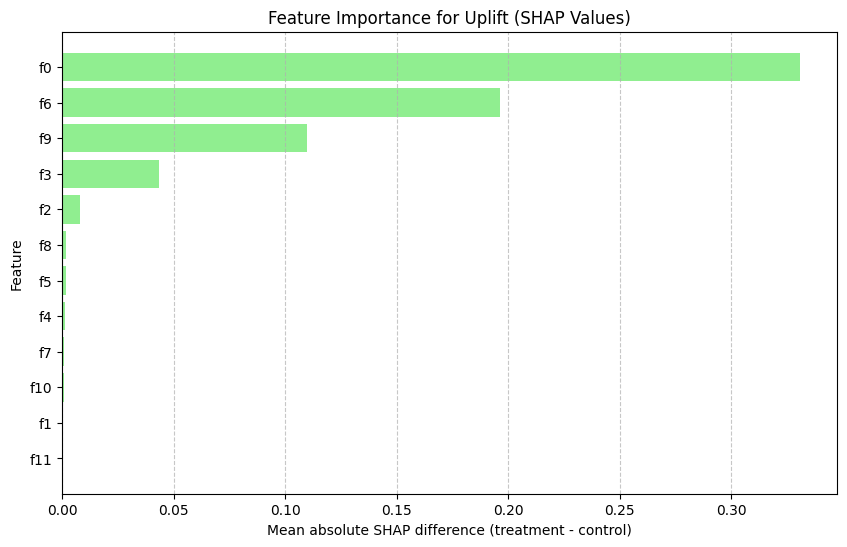

In [21]:
import shap

# Sample for speed if needed (optional)
sample_df = df[feature_cols].sample(n=100000, random_state=42)

# Initialize SHAP explainers
explainer_treat = shap.Explainer(model_treatment.named_steps['logreg'], sample_df)
explainer_ctrl  = shap.Explainer(model_control.named_steps['logreg'], sample_df)

# Compute SHAP values
shap_treat = explainer_treat(sample_df)
shap_ctrl  = explainer_ctrl(sample_df)

# Compute differential SHAP for uplift
shap_diff = shap_treat.values - shap_ctrl.values

# Aggregate absolute importance per feature
mean_abs_shap_diff = np.abs(shap_diff).mean(axis=0)

# Sort features
sorted_idx = np.argsort(mean_abs_shap_diff)[::-1]


plt.figure(figsize=(10,6))
plt.barh([feature_cols[i] for i in sorted_idx], mean_abs_shap_diff[sorted_idx], color='lightgreen')
plt.xlabel("Mean absolute SHAP difference (treatment - control)")
plt.ylabel("Feature")
plt.title("Feature Importance for Uplift (SHAP Values)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


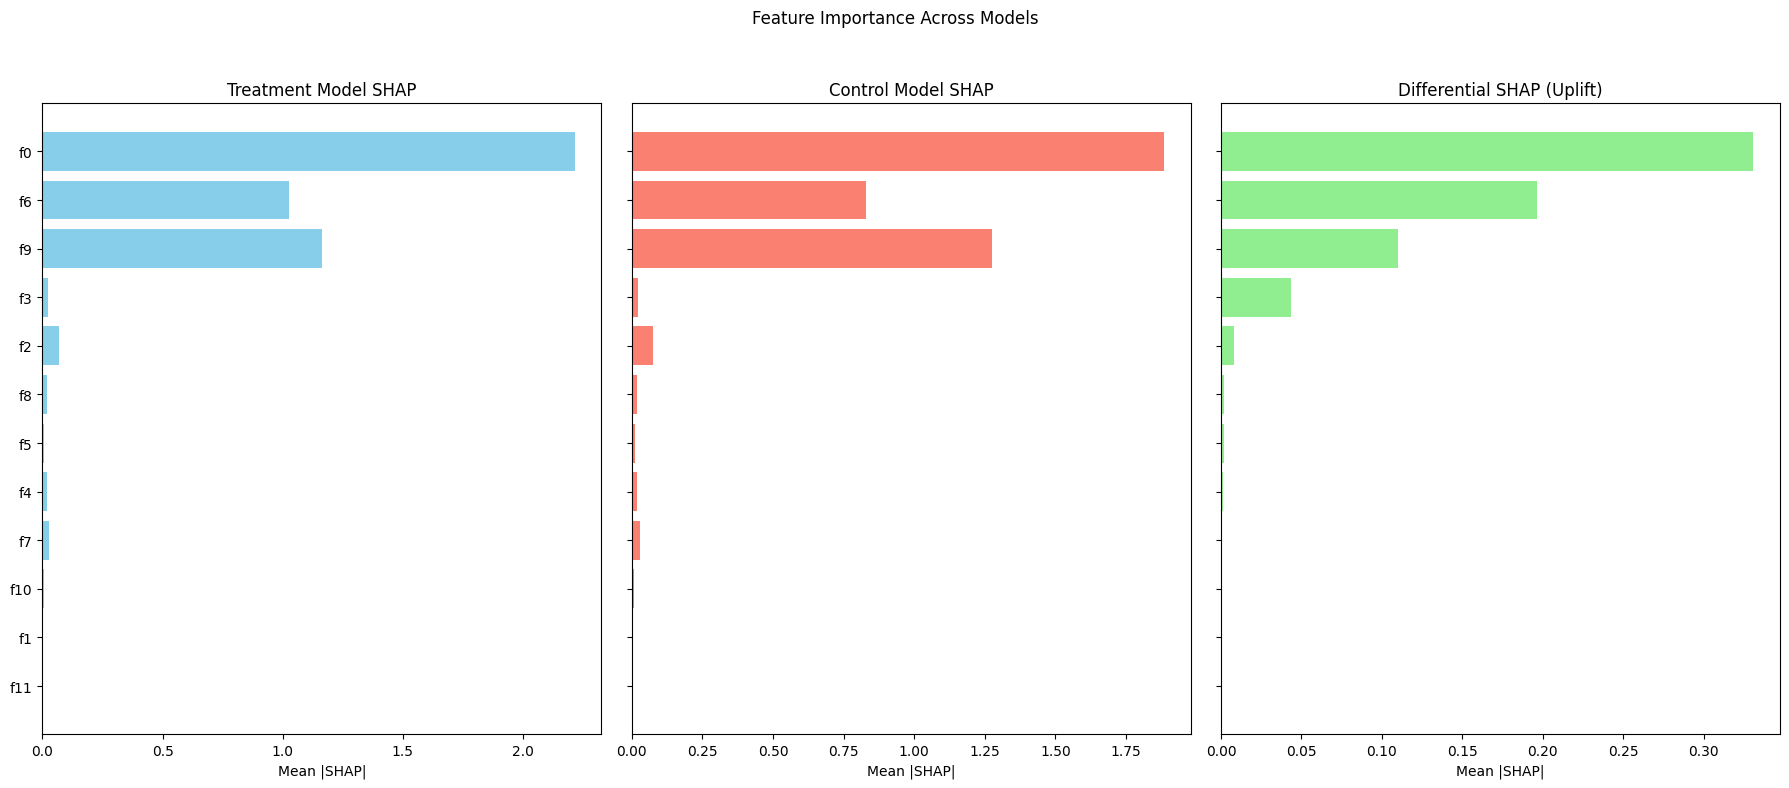

In [22]:
# Aggregate absolute SHAP values per feature
mean_abs_shap_treat = np.abs(shap_treat.values).mean(axis=0)
mean_abs_shap_ctrl  = np.abs(shap_ctrl.values).mean(axis=0)
mean_abs_shap_diff  = np.abs(shap_diff).mean(axis=0)

# Sort features by differential SHAP for uplift
sorted_idx = np.argsort(mean_abs_shap_diff)[::-1]
sorted_features = [feature_cols[i] for i in sorted_idx]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

axes[0].barh(sorted_features, mean_abs_shap_treat[sorted_idx], color='skyblue')
axes[0].set_title("Treatment Model SHAP")
axes[0].invert_yaxis()
axes[0].set_xlabel("Mean |SHAP|")

axes[1].barh(sorted_features, mean_abs_shap_ctrl[sorted_idx], color='salmon')
axes[1].set_title("Control Model SHAP")
axes[1].invert_yaxis()
axes[1].set_xlabel("Mean |SHAP|")

axes[2].barh(sorted_features, mean_abs_shap_diff[sorted_idx], color='lightgreen')
axes[2].set_title("Differential SHAP (Uplift)")
axes[2].invert_yaxis()
axes[2].set_xlabel("Mean |SHAP|")

plt.suptitle("Feature Importance Across Models")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Top 10%



In [30]:
top_pct = 0.10
k = int(len(df_sorted) * top_pct)

df_top10 = df_sorted.iloc[:k]
df_rest  = df_sorted.iloc[k:]


print(f"Uplift medio top 10%: {df_top10['uplift_score'].mean():.6f}")
print(f"Uplift medio global: {df_sorted['uplift_score'].mean():.6f}")
print(f"Uplift medio resto: {df_rest['uplift_score'].mean():.6f}")



Uplift medio top 10%: 0.007928
Uplift medio global: 0.001001
Uplift medio resto: 0.000232


In [31]:
# Conversion rates
treat_rate_top = df_top10[df_top10["treatment"] == 1]["conversion"].mean()
ctrl_rate_top  = df_top10[df_top10["treatment"] == 0]["conversion"].mean()

treat_rate_glob = df[df["treatment"] == 1]["conversion"].mean()
ctrl_rate_glob  = df[df["treatment"] == 0]["conversion"].mean()

uplift_top = treat_rate_top - ctrl_rate_top
uplift_global = treat_rate_glob - ctrl_rate_glob

print("Observed uplift – Top 10%:", uplift_top)
print("Observed uplift – Global:", uplift_global)
print("Lift factor:", uplift_top / uplift_global)


Observed uplift – Top 10%: 0.008114074485508691
Observed uplift – Global: 0.0011518730521316279
Lift factor: 7.044243695512265


In [32]:
total_uplift = df_sorted["uplift_score"].sum()
top_uplift = df_top10["uplift_score"].sum()

print("Share of total predicted uplift in top 10%:",
      top_uplift / total_uplift)


Share of total predicted uplift in top 10%: 0.7918224346320234


In [33]:
positive_uplift_ratio = (df_top10["uplift_score"] > 0).mean()
print("Positive uplift ratio in top 10%:", positive_uplift_ratio)


Positive uplift ratio in top 10%: 1.0


The analysis shows that uplift is highly concentrated in a small fraction of the population. By targeting only the top 10% of users ranked by predicted uplift, we achieve a significantly higher incremental conversion rate compared to random targeting, while covering only a limited portion of the user base. This confirms that uplift modeling enables efficient treatment allocation and provides a clear operational strategy for marketing interventions.